In [1]:
import sys
sys.path.append('..')
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import datetime
import theano_lstm
import numpy as np
import data_managers
import os
import cPickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X


In [2]:
%%time
# Create network 
config.mode="FAST_RUN"
hidden_size = 256
network = theano_lstm.lstm_rnn(300,
                  [(hidden_size, hidden_size),
                   (hidden_size, hidden_size)],
                  150, dropout=0.2)
network.initialize_training_adam()

CPU times: user 3min 46s, sys: 1.64 s, total: 3min 47s
Wall time: 3min 46s


In [8]:
network.save_model('ban.pkl')

In [ ]:
%%time
# Load 
with open('ban.pkl', 'rb') as f:
    network = cPickle.load(f)

In [9]:
data_butler = data_managers.character_data_manager('/home/arimorcos/Github/CS281-Final-Project/data manager/',
                                                   max_doc_loads=2000)
data_butler.convert_ent_to_one_hot()

Now offering: Training data!


In [10]:
# A function to inspect gradients
grad_fun = function(network._lstm_rnn__inp_list, network.adam_grads[0])

In [11]:
# Nice function for doing some of the plotting below
def plot_activation_deets( ax_list, labels, ax2, network, vectors, lengths ):
    hidden_players = network.hidden_activations(vectors[:,:,:2])
    for ax,gtp,title in zip(ax_list, hidden_players, labels):
        ax.imshow(gtp[:lengths[1],:,1]-gtp[:lengths[0],:,0])
        ax.set_title(title)
        ax.set_yticks([])
        ax.set_xticks([])
        
    ax2.cla();
    ax2.plot( 
        np.mean(np.abs(hidden_players[4][:lengths[1],:,1]-hidden_players[4][:lengths[0],:,0]),axis=1) );
    ax2.set_xlim([0,lengths[0]]);

## Check to make sure your initialization conditions are good:

In [106]:
# Re-initializing method for this set-up
net_scale_down = [[0.46, 0.34], .2]
forget_offset = [0.38, 0.28]

network.initialize_network_weights(scale_down=net_scale_down, b_f_offset=forget_offset)

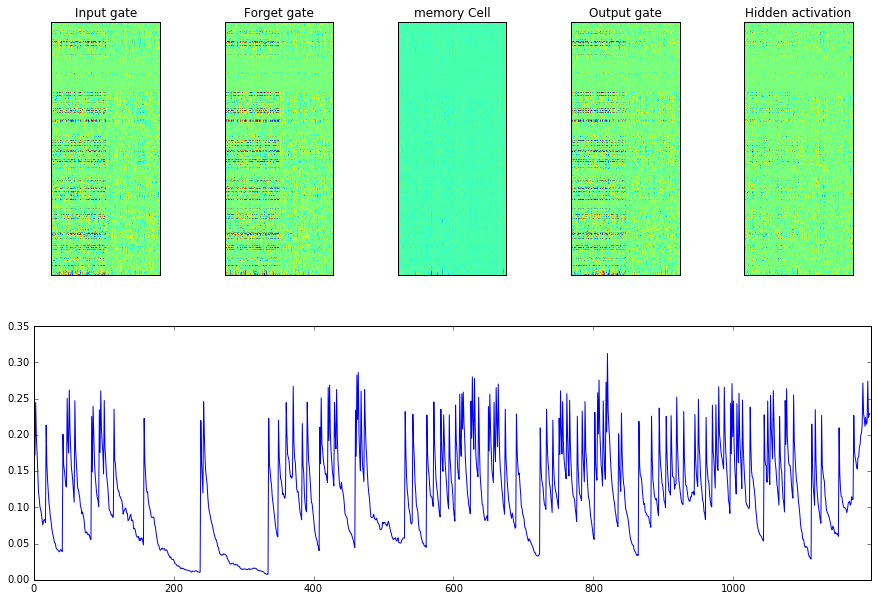

In [107]:
# Check if these initialization conditions create a network with memory

data_butler.set_perms_per(2,disp=False)
vectors, lengths, answers = data_butler.offer_data()
data_butler.advance_schedule()

fig = plt.figure(figsize=(15, 10))
labels = ['Input gate','Forget gate','memory Cell','Output gate','Hidden activation']
ax_list = []
for sp in range(len(labels)):
    ax_list.append(fig.add_subplot(2,len(labels),sp+1))
axD = fig.add_subplot(2,1,2)

plot_activation_deets( ax_list, labels, axD, network, vectors, lengths)
# These plots should NOT look sparse. The bottom one should not hit zero once it gets above it!

In [108]:
# Check if these initialization conditions are providing reasonable gradients:
#
# This should give us a bunch of very similar numbers that aren't 0 or NaN or Inf
np.linalg.norm(grad_fun(vectors, lengths, answers), axis=1)[0:50]

array([ 4.99999952,  5.        ,  5.        ,  5.        ,  5.        ,
        5.        ,  4.99999952,  5.00000048,  4.99999952,  4.99999952,
        5.        ,  5.        ,  5.        ,  5.        ,  5.00000048,
        5.        ,  4.99999952,  5.        ,  5.        ,  5.        ,
        5.        ,  5.        ,  5.        ,  5.        ,  4.99999952,
        5.        ,  5.        ,  5.        ,  5.00000048,  5.        ,
        5.        ,  4.99999952,  5.        ,  5.        ,  5.00000048,
        4.99999952,  5.        ,  5.        ,  5.        ,  5.        ,
        5.00000048,  5.        ,  5.        ,  5.        ,  5.00000048,
        5.        ,  5.        ,  5.        ,  5.        ,  5.        ], dtype=float32)

# Training:

In [115]:
# Function to ensure we're using data meeting the minimal requirement for the plotting we want
def offer_with_one_double(butler):
    # Get the batch size/perms per we're supposed to use
    b_size = butler.get_batch_size()
    p_per  = butler.get_perms_per()
    # Temporarily set the batch size to one and perms per to one
    butler.set_batch_size(1, disp=False)
    butler.set_perms_per(1, disp=False)
    # Get a permutation of the first guy up
    vec1, len1, ans1 = butler.offer_data()
    # Return to the "actual" batch size and perms per
    butler.set_batch_size(b_size, disp=False)
    butler.set_perms_per(p_per, disp=False)
    # Get the rest of the offering
    vectors, lengths, answers = butler.offer_data()
    # Concatenate this with the single query from before, so the first two queries represent a permuted pair
    vectors = np.dstack((np.pad(vec1,((0,vectors.shape[0]-vec1.shape[0]),(0,0),(0,0)),'constant'), vectors))
    lengths = len1 + lengths
    answers = np.hstack((ans1, answers))
    return vectors, lengths, answers

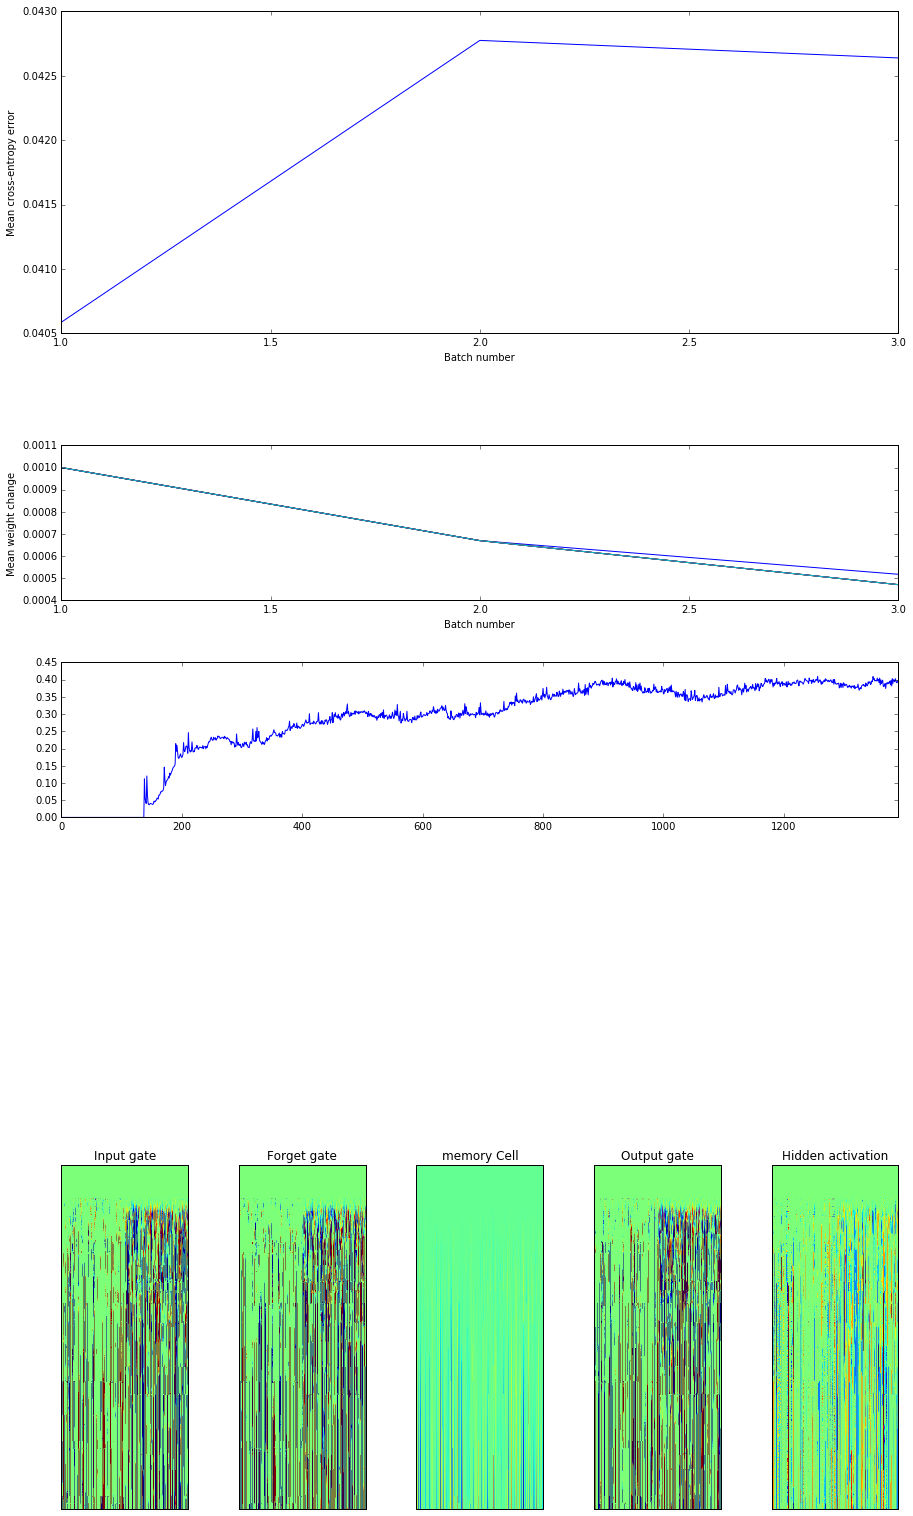

In [ ]:
# Big Ass Cell...

batch_size = 80
perms_per = 1
num_batches = 100000
should_reinitialize = True
repeat_batch = 1

data_butler.set_batch_size(batch_size)
data_butler.set_perms_per(perms_per)
data_butler.set_stride(batch_size)

# Re-initialize network 
if should_reinitialize:
    network.initialize_network_weights(scale_down=net_scale_down, b_f_offset=forget_offset)
    network.reset_adam(grad_max_norm=5, alpha=.001)
    root_dir = '/media/1_TB_Internal/lstm_rnn_data'
    new_log_dir = os.path.join(root_dir, datetime.datetime.now().strftime('%y%m%d_%H%M%S'))
    network.set_log_dir(new_log_dir)
    
    # Initialize cost 
    cost = []
    mean_diff_mag = []
    mean_diff_mag_i = []
    mean_diff_mag_f = []
    mean_diff_mag_c = []
    mean_diff_mag_o = []
    mean_diff_mag_y = []
    mean_diff_mag_r = []
    should_crop = True

#Create plot 
fig = plt.figure(figsize=(15, 30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax_cost = fig.add_subplot(4,1,1)
ax_cost.set_xlabel('Batch number')
ax_cost.set_ylabel('Mean cross-entropy error')
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax_cost.yaxis.set_major_formatter(y_formatter)

# ax_weight_change = fig.add_subplot(8,1,3)
# ax_weight_change.set_xlabel('Batch number')
# ax_weight_change.set_ylabel('Mean weight change')

ax_weight_change_ind = fig.add_subplot(8,1,3)
ax_weight_change_ind.set_xlabel('Batch number')
ax_weight_change_ind.set_ylabel('Mean weight change')
ax_weight_change_ind.hold(True)

# Plot the difference in hidden unit activations comparing different permutations (assumes perms_per > 1)
labels = ['Input gate','Forget gate','memory Cell','Output gate','Hidden activation']
ax_list = []
for sp in range(len(labels)):
    ax_list.append(fig.add_subplot(2,len(labels),(1*len(labels))+sp+1))
axD = fig.add_subplot(8,1,4)


# # Offer data
# vectors, lengths, answers = data_butler.offer_data()

for batch in range(num_batches):
    
#     # Get data
#     vectors, lengths, answers = data_butler.permute_examples()

    # Get fresh data, with at least one permuted pair at the start
    vectors, lengths, answers = offer_with_one_double(data_butler)
    
    for repeat in range(repeat_batch):
        temp_cost, param_diff = network.adam_step(vectors, lengths, answers)
        cost.append(temp_cost.tolist())
    
        # Calculate mean param_diff magnitude
        temp_mean_diff_mag = [np.abs(diff).mean() for diff in param_diff]
        mean_diff_mag.append(np.mean(temp_mean_diff_mag))
        
        # append indi
        mean_diff_mag_i.append(temp_mean_diff_mag[0])
        mean_diff_mag_f.append(temp_mean_diff_mag[2])
        mean_diff_mag_c.append(temp_mean_diff_mag[4])
        mean_diff_mag_o.append(temp_mean_diff_mag[6])
        mean_diff_mag_y.append(temp_mean_diff_mag[8])
        mean_diff_mag_r.append(temp_mean_diff_mag[10])

        # Update plot 
        try:
            upper_lim = len(cost) + 1
        except:
            upper_lim = 2
        x_vals = range(1, upper_lim)
        x_vals_diff = range(1, upper_lim)
        if len(cost) > 5 and should_crop:
            should_crop = False
            mean_diff_mag = mean_diff_mag[5:]
            mean_diff_mag_r = mean_diff_mag_r[5:]
            mean_diff_mag_y = mean_diff_mag_y[5:]
            mean_diff_mag_i = mean_diff_mag_i[5:]
            mean_diff_mag_f = mean_diff_mag_f[5:]
            mean_diff_mag_c = mean_diff_mag_c[5:]
            mean_diff_mag_o = mean_diff_mag_o[5:]
            x_vals_diff = range(6, len(mean_diff_mag) + 6)
#             ax_weight_change.cla()
            ax_weight_change_ind.cla()
#             ax_weight_change.set_xlabel('Batch number')
#             ax_weight_change.set_ylabel('Mean weight change')
            ax_weight_change_ind.set_xlabel('Batch number')
            ax_weight_change_ind.set_ylabel('Mean weight change')
        if not should_crop:
            x_vals_diff = range(6, len(mean_diff_mag) + 6)
        ax_cost.plot(x_vals, cost, 'b')
#         ax_weight_change.plot(x_vals_diff, mean_diff_mag, 'r')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_i, 'b')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_f, 'r')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_c, 'g')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_o, 'k')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_y, 'm')
        ax_weight_change_ind.plot(x_vals_diff, mean_diff_mag_r, 'c')
        
        
        plot_activation_deets( ax_list, labels, axD, network, vectors, lengths )
        
        display.clear_output(wait=True)
        display.display(fig)
    
    # Move to the next part of the data!
    data_butler.advance_schedule()

In [ ]:
cost

In [ ]:
mean_diff_mag_y[:] = mean_diff_mag_c[5]

In [ ]:
network.initialize_network_weights()
network.do_max_norm_reg()
p = network.list_all_params()
w_i = p[0].get_value()
norms = []
for row in range(w_i.shape[0]):
    norms.append(np.linalg.norm(w_i[row, :]))
plt.plot(norms)

In [ ]:
# network.initialize_network_weights()

# p = network.list_all_params()
# for P in p:
#     P.set_value(P.get_value()*0.6)
#     P.set_value(np.random.uniform(
#             low=-1./np.sqrt(128),
#             high=1./np.sqrt(128),
#             size=P.get_value().shape
#         ).astype(config.floatX))
# network.do_max_norm_reg()

labels = ['Input gate','Forget gate','memory Cell','Output gate','Hidden activation']
fig = plt.figure(figsize=(15,10))

ax_list = []
for sp in range(len(labels)):
    ax_list.append(fig.add_subplot(1,len(labels),sp+1))

hidden_players = network.hidden_activations(vectors[:,:,:2])
for ax,gtp,T in zip(ax_list, hidden_players, labels):
    ax.imshow(gtp[:lengths[1],:,1]-gtp[:lengths[0],:,0])
    #ax.imshow(gtp[:,:,0])
    ax.set_title(T)
    
plt.figure()
plt.axes().plot( np.mean(np.abs(hidden_players[4][:lengths[1],:256,1]-hidden_players[4][:lengths[0],:256,0]),axis=1) );

In [ ]:
plt.hist(hidden_players[2][-10:, :].flatten(), bins=50);